# CSCI 6920 - Homework 5
Name: Ohad Nir;
Due: 11/04/2022

## Problem Statement 
Image classification is a very challenging task when the objects in the images have a lot of differences in pose, lighting and orintation. CNNs have been shown to do a good job at solving this classical computer vision problem. In this homework I'll use convoltuional nural networks on the CIFAR10 dataset.

On the second part of this homework I will implment a VAE model on the fashion MNIST dataset and a GANs on the CIFAR10 dataset.

## Setup

In [200]:
import os
import random
from glob import glob
import time

import cv2
import PIL

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from IPython import display
import imageio

import albumentations as A

import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow_probability as tfp
import tensorflow_docs.vis.embed as embed

import sklearn

import matplotlib.pyplot as plt
import seaborn as sns

## Task 1

### Dataset Construction

In [201]:
# set dataset parameters.
SHUFFLE_BUFFER_SIZE = 100
batch_size = 32
valid_size = 0.15

In [202]:
# construct training, validation and testing sets.
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X_train, y_train, test_size=valid_size, stratify=y_train)

n_classes = len(np.unique(y_train))

print(f"Training set: {len(X_train)} images | Validation set: {len(X_valid)} | Testing set: {len(X_test)} images | {n_classes} classes in the dataset.")

Training set: 42500 images | Validation set: 7500 | Testing set: 10000 images | 10 classes in the dataset.


In [204]:
# normalize datasets
X_norm_train = X_train / 255.0
X_norm_valid = X_valid / 255.0
X_norm_test = X_test / 255.0

# construct dataset generators.
train_dataset = tf.data.Dataset.from_tensor_slices((X_norm_train, y_train)).shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_norm_valid, y_valid)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_norm_test, y_test)).batch(batch_size)

In [205]:
CIFAR10_LABELS_LIST = [
    'airplane', 
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

### Data Visualization

In [206]:
def display_images(X, y, classes):
    n_classes = len(np.unique(y))

    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
    axs = axs.flatten()

    for c, ax in enumerate(axs):
        class_idx = np.where(y == c)[0][0]
        label = classes[c]
        x = X[class_idx]

        ax.imshow(x)
        ax.set_title(label)
        ax.axis("off")

    plt.show()

def class_balance(y, classes):
    sns.countplot(y=np.array(classes)[y].flatten())

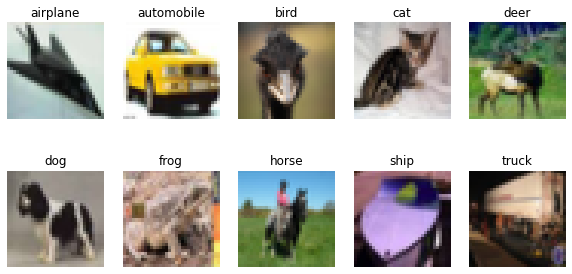

In [207]:
display_images(X_train, y_train, CIFAR10_LABELS_LIST)

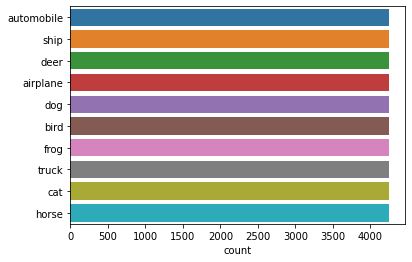

In [208]:
class_balance(y_train, CIFAR10_LABELS_LIST)

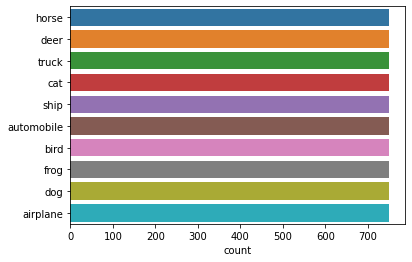

In [209]:
class_balance(y_valid, CIFAR10_LABELS_LIST)

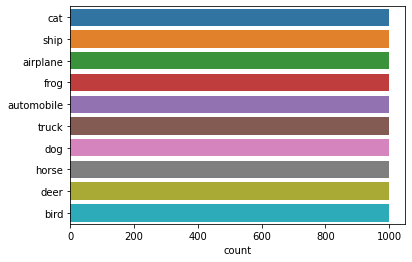

In [210]:
class_balance(y_test, CIFAR10_LABELS_LIST)

### Part 1 - Convolutional Model

In [211]:
def create_convolutional_model(num_classes, dropout_prob):
    return tf.keras.Sequential([
        keras.layers.InputLayer(input_shape=(32,32,3)),
        keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', strides=1), #padding="same"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', strides=1), #padding="same"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', strides=1), #padding="same"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Flatten(),
        keras.layers.Dropout(rate=dropout_prob),        
        keras.layers.Dense(units=1028, activation='relu'),
        keras.layers.Dense(num_classes)
    ])

#### Architecture Explination
For my architecture I choose to have three sequences of convolutional, relu activation and max pool layers. Each layer expands the number of channels by a power of 2 (i.e. 16, 32, 64). I chose to only have three conolutional steps as the dataset has images that are only 32x32 pixels in width and hieght so I didn't want to make the network too deep and make the model overfit.

#### Convolutional Model Training

Hyperparameters:

In [212]:
epochs = 20
dp_rate = 0.3
learning_rate = 0.01

In [213]:
conv_model = create_convolutional_model(n_classes, dp_rate)
conv_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 15, 15, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 2, 2, 64)        

In [214]:
conv_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

cm_history = conv_model.fit(x=train_dataset, epochs=epochs, validation_data=valid_dataset).history

Epoch 1/20
1329/1329 [==============================] - 7s 5ms/step - loss: 1.6569 - accuracy: 0.3850 - val_loss: 1.4208 - val_accuracy: 0.4912
Epoch 2/20
1329/1329 [==============================] - 6s 4ms/step - loss: 1.3425 - accuracy: 0.5153 - val_loss: 1.2144 - val_accuracy: 0.5596
Epoch 3/20
1329/1329 [==============================] - 6s 5ms/step - loss: 1.2274 - accuracy: 0.5601 - val_loss: 1.1254 - val_accuracy: 0.6007
Epoch 4/20
1329/1329 [==============================] - 6s 4ms/step - loss: 1.1518 - accuracy: 0.5885 - val_loss: 1.0781 - val_accuracy: 0.6163
Epoch 5/20
1329/1329 [==============================] - 6s 5ms/step - loss: 1.0915 - accuracy: 0.6113 - val_loss: 1.0318 - val_accuracy: 0.6340
Epoch 6/20
1329/1329 [==============================] - 6s 5ms/step - loss: 1.0380 - accuracy: 0.6289 - val_loss: 1.0160 - val_accuracy: 0.6421
Epoch 7/20
1329/1329 [==============================] - 6s 5ms/step - loss: 0.9997 - accuracy: 0.6452 - val_loss: 0.9797 - val_accuracy:

#### Convolutional Model Evaluation

In [215]:
def plot_train_hist(history):
    epochs = len(history["loss"])
  
    plt.plot(history["loss"], label="Training Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks(range(0, epochs, 4))
    plt.show()

    plt.plot(history["accuracy"], label="Training Accuracy")
    plt.plot(history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.xticks(range(0, epochs, 4))
    plt.show()
    
def auc_confusion_matrix(model, dataset, y, classes, dset_name):
    y_pred = model.predict(dataset, verbose=0)

    y_prob = tf.nn.softmax(y_pred)
    y_hat = tf.math.argmax(y_pred, axis=1)
    
    cm = sklearn.metrics.confusion_matrix(y, y_hat)
    sns.heatmap(cm, 
                xticklabels=classes, 
                yticklabels=classes, 
                annot=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{dset_name} Set Confusion Matrix")
    plt.show()

    return sklearn.metrics.roc_auc_score(y, y_prob, multi_class="ovr")

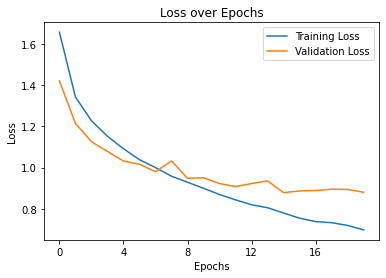

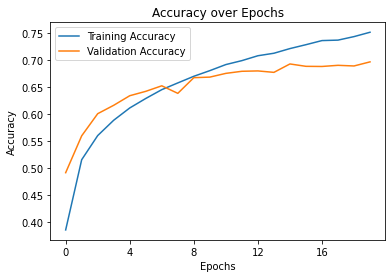

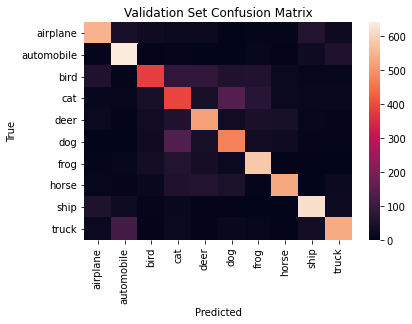

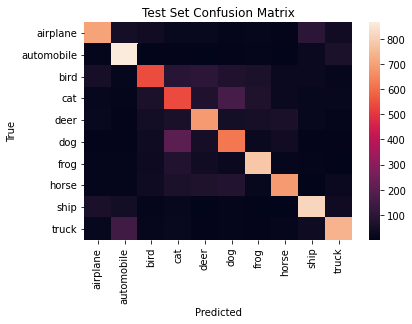

Convolutional model got 0.8799 loss on the validation set and 0.8818 loss on the test set.
Convolutional model got 69.68% accuracy on the validation set and 69.87% accuracy on the test set.
Convolutional model got 0.9530 AUC on the validation set and 0.9525 AUC on the test set.


In [216]:
plot_train_hist(cm_history)
valid_loss, valid_acc = conv_model.evaluate(valid_dataset, batch_size=batch_size, verbose=0)
test_loss, test_acc = conv_model.evaluate(test_dataset, batch_size=batch_size, verbose=0)

valid_auc = auc_confusion_matrix(conv_model, valid_dataset, y_valid, CIFAR10_LABELS_LIST, "Validation")
test_auc = auc_confusion_matrix(conv_model, test_dataset, y_test, CIFAR10_LABELS_LIST, "Test")

print(f"Convolutional model got {valid_loss:.4f} loss on the validation set and {test_loss:.4f} loss on the test set.")
print(f"Convolutional model got {valid_acc*100:.2f}% accuracy on the validation set and {test_acc*100:.2f}% accuracy on the test set.")
print(f"Convolutional model got {valid_auc:.4f} AUC on the validation set and {test_auc:.4f} AUC on the test set.")

#### Evaluation and Metric Discussion
The convolutional model achived an accuracy of 69.68% on the validation set and a 69.87% on the testing set.

The metric I choose for the model evalutation is area under the curve. I choose this metric as its a standard for evaluting model. AUC is optained by computing the persition recall curve and then taking the area under this curve. Thus 0 is the worst score and 1 is the best score.

My model achived a AUC score of 0.953 on the validation set and a 0.9525 AUC score on the test set.

### Part 2 - Proven Architecture: ResNet50

#### ResNet50 Training

In [217]:
train_dataset = tf.data.Dataset.from_tensor_slices((preprocess_input(X_train), y_train)).shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
valid_dataset = tf.data.Dataset.from_tensor_slices((preprocess_input(X_valid), y_valid)).batch(batch_size)
train_dataset = tf.data.Dataset.from_tensor_slices((preprocess_input(X_test), y_test)).batch(batch_size)

In [218]:
resnet50_fe = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
flattened = tf.keras.layers.Flatten()(resnet50_fe.output)
fc1 = tf.keras.layers.Dense(1024, activation=keras.layers.LeakyReLU())(flattened)
fc2 = tf.keras.layers.Dense(n_classes)(fc1)
resnet50_model = tf.keras.models.Model(inputs=resnet50_fe.input, outputs=fc2)

In [219]:
resnet50_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

r50_history = resnet50_model.fit(x=train_dataset, epochs=10, validation_data=valid_dataset).history

Epoch 1/10
313/313 [==============================] - 21s 50ms/step - loss: 2.6806 - accuracy: 0.3376 - val_loss: 112.4768 - val_accuracy: 0.1284
Epoch 2/10
313/313 [==============================] - 15s 48ms/step - loss: 1.7805 - accuracy: 0.4211 - val_loss: 60.7342 - val_accuracy: 0.4253
Epoch 3/10
313/313 [==============================] - 15s 48ms/step - loss: 1.5653 - accuracy: 0.4976 - val_loss: 2.5973 - val_accuracy: 0.5335
Epoch 4/10
313/313 [==============================] - 15s 48ms/step - loss: 1.4113 - accuracy: 0.5418 - val_loss: 1.3341 - val_accuracy: 0.5225
Epoch 5/10
313/313 [==============================] - 15s 49ms/step - loss: 1.1929 - accuracy: 0.5948 - val_loss: 3.1215 - val_accuracy: 0.4773
Epoch 6/10
313/313 [==============================] - 15s 49ms/step - loss: 1.2030 - accuracy: 0.6121 - val_loss: 6.4828 - val_accuracy: 0.2072
Epoch 7/10
313/313 [==============================] - 15s 49ms/step - loss: 1.4174 - accuracy: 0.5165 - val_loss: 1.2338 - val_accura

#### ResNet50 Evaluation

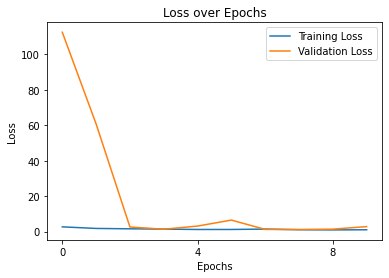

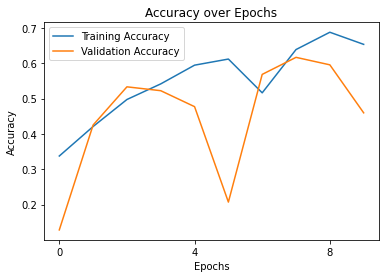

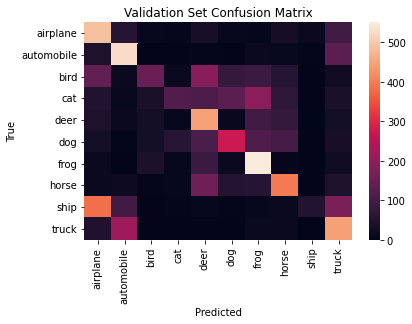

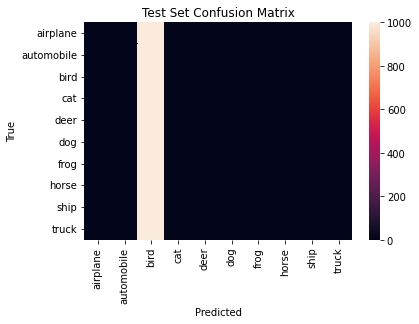

ResNet50 model got 2.8126 loss on the validation set and 3.3017 loss on the test set.
ResNet50 model got 45.99% accuracy on the validation set and 10.00% accuracy on the test set.
ResNet50 model got 0.8422 AUC on the validation set and 0.5261 AUC on the test set.


In [229]:
plot_train_hist(r50_history)
valid_loss, valid_acc = resnet50_model.evaluate(valid_dataset, batch_size=batch_size, verbose=0)
test_loss, test_acc = resnet50_model.evaluate(test_dataset, batch_size=batch_size, verbose=0)

valid_auc = auc_confusion_matrix(resnet50_model, valid_dataset, y_valid, CIFAR10_LABELS_LIST, "Validation")
test_auc = auc_confusion_matrix(resnet50_model, test_dataset, y_test, CIFAR10_LABELS_LIST, "Test")

print(f"ResNet50 model got {valid_loss:.4f} loss on the validation set and {test_loss:.4f} loss on the test set.")
print(f"ResNet50 model got {valid_acc*100:.2f}% accuracy on the validation set and {test_acc*100:.2f}% accuracy on the test set.")
print(f"ResNet50 model got {valid_auc:.4f} AUC on the validation set and {test_auc:.4f} AUC on the test set.")

#### Evaluation and Metric Discussion
For my pretrain model experiment I used resnet50 which was pretrained on the ImageNet dataset. This model performed worst then my convolutional model. It achived a both a lower accuracy and AUC. I beleive it performed worst as the resnet50 model is a very deep model so by the 50th residual layer the input, which was 32x32x3 in the beginning, would have been streched to have a very lower receptive field which could of hold important feature infromation. It's likely that the model was unable to use the information it learned from the pretraining on ImageNet as the imagenet images are 224x224x3 so that pretrained learning wouldn't have that useful.

### Convolutional Model with Augmentations

In [246]:
gen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)
gen.fit(X_train / 255.)
train_aug_dataset = gen.flow(X_train / 255., y_train, batch_size=32)

#### Convolutional Model with Augmentations Training 

In [248]:
conv_aug_model = create_convolutional_model(n_classes, dp_rate)
conv_aug_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 15, 15, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 2, 2, 64)       

In [249]:
conv_aug_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

cma_history = conv_aug_model.fit_generator(train_aug_dataset, epochs=10, validation_data=valid_dataset).history

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


1329/1329 [==============================] - 31s 23ms/step - loss: 1.9332 - accuracy: 0.1063 - val_loss: 139.0824 - val_accuracy: 0.0148
Epoch 2/10
1329/1329 [==============================] - 31s 24ms/step - loss: 1.7785 - accuracy: 0.0920 - val_loss: 150.2777 - val_accuracy: 0.0061
Epoch 3/10
1329/1329 [==============================] - 29s 22ms/step - loss: 1.7089 - accuracy: 0.0896 - val_loss: 112.4991 - val_accuracy: 0.0205
Epoch 4/10
1329/1329 [==============================] - 30s 23ms/step - loss: 1.6615 - accuracy: 0.0929 - val_loss: 146.6105 - val_accuracy: 0.0267
Epoch 5/10
1329/1329 [==============================] - 29s 22ms/step - loss: 1.6296 - accuracy: 0.0955 - val_loss: 82.8395 - val_accuracy: 0.0047
Epoch 6/10
1329/1329 [==============================] - 30s 23ms/step - loss: 1.6091 - accuracy: 0.0960 - val_loss: 112.0235 - val_accuracy: 0.0263
Epoch 7/10
1329/1329 [==============================] - 29s 22ms/step - loss: 1.5842 - accuracy: 0.0953 - val_loss: 110.3208

#### Convolutional Model with Augmentations Evaluation

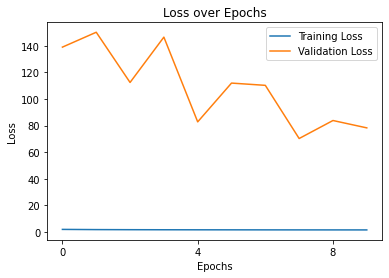

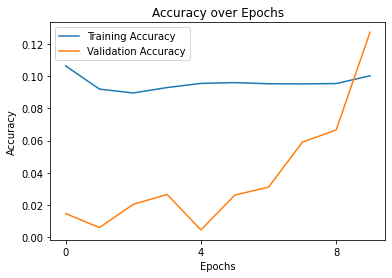

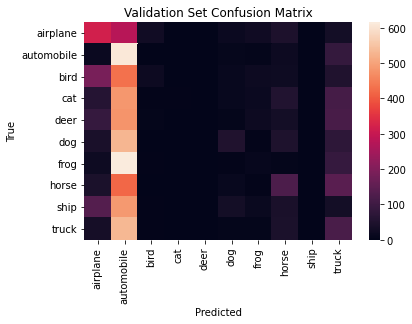

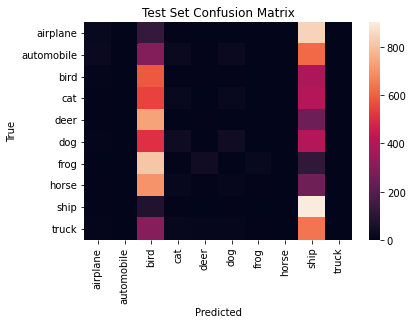

ResNet50 model got 2.8126 loss on the validation set and 3.3017 loss on the test set.
ResNet50 model got 45.99% accuracy on the validation set and 10.00% accuracy on the test set.
ResNet50 model got 0.5809 AUC on the validation set and 0.7273 AUC on the test set.


In [250]:
plot_train_hist(cma_history)
valid_loss, valid_acc = resnet50_model.evaluate(valid_dataset, batch_size=batch_size, verbose=0)
test_loss, test_acc = resnet50_model.evaluate(test_dataset, batch_size=batch_size, verbose=0)

valid_auc = auc_confusion_matrix(conv_aug_model, valid_dataset, y_valid, CIFAR10_LABELS_LIST, "Validation")
test_auc = auc_confusion_matrix(conv_aug_model, test_dataset, y_test, CIFAR10_LABELS_LIST, "Test")

print(f"ResNet50 model got {valid_loss:.4f} loss on the validation set and {test_loss:.4f} loss on the test set.")
print(f"ResNet50 model got {valid_acc*100:.2f}% accuracy on the validation set and {test_acc*100:.2f}% accuracy on the test set.")
print(f"ResNet50 model got {valid_auc:.4f} AUC on the validation set and {test_auc:.4f} AUC on the test set.")

#### Evaluation Discussion
The model seemed to perform much worst with the augmentations. This might be because the augmentations distorged the image to much so the model couldn't find similarties in the data.

## Task 2

### Part 1 - Variational Autoencoder (VAE)
Code from [Convolutional Variational Autoencoder](https://www.tensorflow.org/tutorials/generative/cvae). Used fashion MNIST dataset.

#### Dataset Setup

In [107]:
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

In [108]:
def vae_preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = vae_preprocess_images(train_images)
test_images = vae_preprocess_images(test_images)

In [109]:
batch_size = 32
train_size = len(train_images)
test_size = len(test_images)

In [110]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

#### VAE Model and Helper Functions

In [57]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding='same'),
            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

def vae_generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

def plot_latent_images(model, n, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            image[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()
    plt.clf()

#### Model Training

In [58]:
epochs = 10
latent_dim = 2
num_examples_to_generate = 16

random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(1e-4)

In [59]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -193.21046447753906, time elapse for current epoch: 5.293605804443359


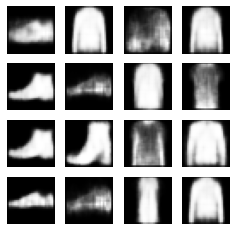

In [60]:
vae_generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
    vae_generate_and_save_images(model, epoch, test_sample)

#### Display Results

Create gif of the per epoch results.

In [61]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


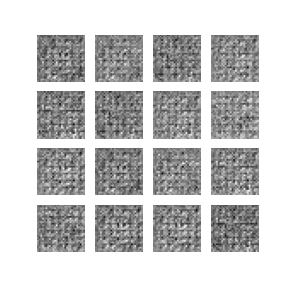

In [62]:
embed.embed_file(anim_file)

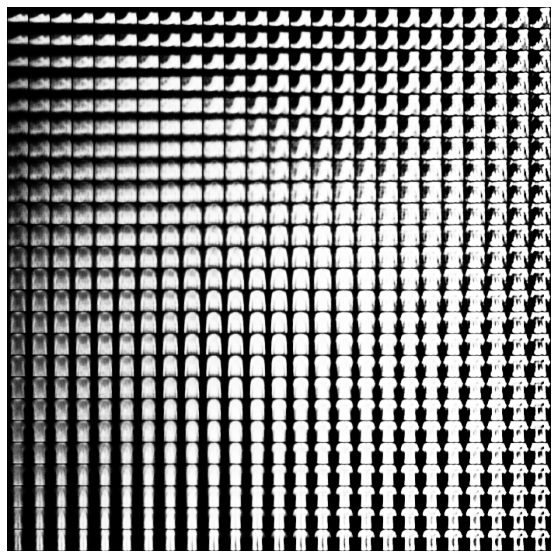

<Figure size 432x288 with 0 Axes>

In [65]:
plot_latent_images(model, 25)

### Part 2 - Generative Adversarial Networks (GANs)

Code from [Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan).

#### Dataset Setup

In [238]:
BUFFER_SIZE = 1000
BATCH_SIZE = 512

In [239]:
def gans_preprocess_images(images):
    gray_images = np.dot(images[...,:3], [0.2989, 0.5870, 0.1140])[..., np.newaxis]
    resized_images = tf.image.resize(gray_images, (28, 28))
    return (resized_images - 0.5) / 0.5

train_images  = gans_preprocess_images(X_train)
valid_images  = gans_preprocess_images(X_valid)
test_images = gans_preprocess_images(X_test)

train_images = np.vstack((train_images, valid_images, test_images))

In [240]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#### GANs Model and Helper Functions

In [248]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def gans_train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return float(gen_loss), float(disc_loss)
    
def gans_train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        gen_loss = 0
        disc_loss = 0
        count = 0
        for image_batch in tqdm(dataset):
            gen_b_loss, disc_b_loss = gans_train_step(image_batch)

            gen_loss += gen_b_loss
            disc_loss += disc_b_loss

            count += 1

        gen_loss = gen_loss / count
        disc_loss = disc_loss / count

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        gans_generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print(f'Time for epoch {epoch + 1} is {time.time()-start} sec. Generator loss: {gen_loss:.6f} | descrimiator loss: {disc_loss:.6f}')

    # Generate after the final epoch
    display.clear_output(wait=True)
    gans_generate_and_save_images(generator,
                           epochs,
                           seed)
    
def gans_generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

tf.Tensor([[-0.00166863]], shape=(1, 1), dtype=float32)


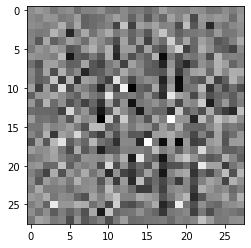

In [249]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

In [250]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [255]:
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [252]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [253]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

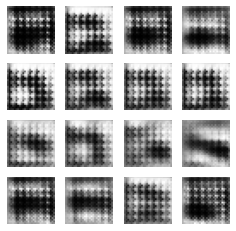

Time for epoch 4 is 21.4032986164093 sec. Generator loss: 0.880598 | descrimiator loss: 1.219979


  0%|          | 0/118 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [256]:
gans_train(train_dataset, EPOCHS)

In [257]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


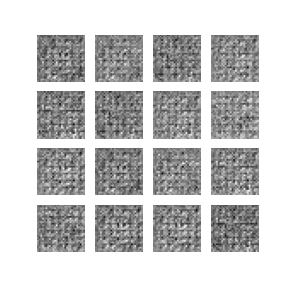

In [258]:
embed.embed_file(anim_file)